# Depth in control: Elevating Image Generation with edge precision#
**Group 3: Shachar Snir, Mor Abrutzky **

# Imports

In [ ]:
!pip install -q torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 diffusers transformers xformers accelerate open3d
!pip install -q git+https://github.com/TRI-ML/dgp
!pip install diffusers
!pip install xformers


In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import torch
from diffusers.utils import load_image
import os
import cv2
import matplotlib.pyplot as plt
import PIL
import numpy as np
from skimage import filters, feature
from scipy.ndimage import gaussian_filter
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import pickle
from transformers import pipeline

import json
from tqdm import tqdm

import random
from transformers import AutoImageProcessor, AutoModelForDepthEstimation,BlipProcessor, BlipForConditionalGeneration
import torch.nn.functional as F

from dgp.datasets.synchronized_dataset import SynchronizedSceneDataset
from dgp.proto.ontology_pb2 import Ontology
from dgp.utils.protobuf import open_pbobject

import requests


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#create dir to save the data set
#!mkdir -p /content/drive/MyDrive/DDAD


In [ ]:
#download the data set
# !curl -s https://tri-ml-public.s3.amazonaws.com/github/DDAD/datasets/DDAD.tar | tar -xv -C /content/DDAD


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the controlnet pretrain

In [ ]:
# Set a random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

generator = torch.Generator(device=device).manual_seed(seed)

pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

depth_estimator = pipeline("depth-estimation")



# READ Train and Validation data

In [ ]:
# Path to the DDAD dataset
dataset_path = '/content/drive/MyDrive/mind the edge/DDAD'


In [ ]:
try:
    from dgp.datasets import SynchronizedSceneDataset
    print("DGP Library imported successfully.")
except ImportError as e:
    print(f"ImportError: {e}")


DGP Library imported successfully.


In [ ]:
# Define high level variables
DDAD_TRAIN_VAL_JSON_PATH = '/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/ddad.json'
DATUMS = ['lidar'] + ['CAMERA_%02d' % idx for idx in [1, 5, 6, 7, 8, 9]]

In [ ]:
# Path to your JSON file
DDAD_TRAIN_VAL_JSON_PATH = '/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/ddad.json'

"""# Read the JSON file
with open(DDAD_TRAIN_VAL_JSON_PATH, 'r') as file:
    data = json.load(file)

# Base path to check for file existence
base_path = '/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val'

# New JSON structure
new_data = {"scene_splits": {}}

# Check for file existence and build new JSON structure
for key, value in data["scene_splits"].items():
    new_data["scene_splits"][key] = {"filenames": []}
    for filename in tqdm(value["filenames"]):
        full_path = os.path.join(base_path, filename)
        if os.path.exists(full_path):
            new_data["scene_splits"][key]["filenames"].append(filename)"""

# Path to save the new JSON file
NEW_DDAD_TRAIN_VAL_JSON_PATH = '/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/ddad_filtered.json'
"""
# Save the new JSON structure to a file
with open(NEW_DDAD_TRAIN_VAL_JSON_PATH, 'w') as file:
    json.dump(new_data, file, indent=2)

del data
print(f"Filtered JSON saved to {NEW_DDAD_TRAIN_VAL_JSON_PATH}")"""

'\n# Save the new JSON structure to a file\nwith open(NEW_DDAD_TRAIN_VAL_JSON_PATH, \'w\') as file:\n    json.dump(new_data, file, indent=2)\n\ndel data\nprint(f"Filtered JSON saved to {NEW_DDAD_TRAIN_VAL_JSON_PATH}")'

In [ ]:
os.environ['JAX_NUM_THREADS'] = '1'

ddad_train = SynchronizedSceneDataset(
    NEW_DDAD_TRAIN_VAL_JSON_PATH,
    split='train',
    datum_names=DATUMS,
    generate_depth_from_datum='lidar'
)
print('Loaded DDAD train split containing {} samples'.format(len(ddad_train)))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loaded DDAD train split containing 1100 samples


# Finetune the depth estimator

## Calculate edge probaility from depth map

In [ ]:
def edge_probabilities(depth_map, low_threshold=0.85, high_threshold=0.9):
    """
    Calculate edge probabilities based on depth map.

    Args:
        depth_map (torch.Tensor): Depth map tensor of shape (batch_size, height, width).
        low_threshold (float): Low threshold for hysteresis thresholding.
        high_threshold (float): High threshold for hysteresis thresholding.

    Returns:
        torch.Tensor: Edge probabilities.
    """
    device = depth_map.device  # Get the device from the tensor
    depth_map_np = depth_map.detach().cpu().numpy()  # Convert to NumPy array
    batch_size, height, width = depth_map_np.shape

    edge_probabilities = []

    for i in range(batch_size):
        # Step 1: Compute gradient magnitude
        gradient_magnitude = sobel(depth_map_np[i])

        # Step 2: Apply Canny edge detection with hysteresis thresholding
        edges = feature.canny(gradient_magnitude, low_threshold=low_threshold, high_threshold=high_threshold)

        # Step 3: Calculate probabilities
        probabilities = np.zeros_like(depth_map_np[i], dtype=np.float32)
        probabilities[edges] = 1.0  # Strong edges

        # Optional: Gaussian smoothing of probabilities
        probabilities = gaussian_filter(probabilities, sigma=1.0)

        edge_probabilities.append(probabilities)

    edge_probabilities = np.array(edge_probabilities)
    edge_probabilities = torch.tensor(edge_probabilities, dtype=torch.float32)

    # Move tensor to the same device as depth_map
    edge_probabilities = edge_probabilities.to(device)

    return edge_probabilities

def sobel(depth_map):
    """
    Compute the gradient magnitude using Sobel filters.

    Args:
        depth_map (np.ndarray): Depth map array of shape (height, width).

    Returns:
        np.ndarray: Gradient magnitude.
    """
    gradient_x = cv2.Sobel(depth_map, cv2.CV_64F, 1, 0, ksize=5)
    gradient_y = cv2.Sobel(depth_map, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    return gradient_magnitude


## EDB

In [ ]:
def EDB(depth_map, t_grad=0.5):
    """
    Calculate the edge detection-based depth (EDB) probabilities.

    Args:
        depth_map (torch.Tensor): Depth map tensor of shape (batch_size, height, width).
        t_grad (float): Gradient threshold.

    Returns:
        torch.Tensor: Edge probabilities.
    """
    device = depth_map.device  # Get the device from the tensor
    depth_map_np = depth_map.detach().cpu().numpy()  # Convert to NumPy array
    batch_size, height, width = depth_map_np.shape

    edge_probabilities = []

    for i in range(batch_size):
        # Calculate gradients using OpenCV
        gradient_x = cv2.Sobel(depth_map_np[i], cv2.CV_64F, 1, 0, ksize=5)
        gradient_y = cv2.Sobel(depth_map_np[i], cv2.CV_64F, 0, 1, ksize=5)

        # Combine the gradients
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

        # Calculate E~(D(I)) using sigmoid
        sigmoid_output = 1 / (1 + np.exp(-(gradient_magnitude - t_grad)))

        edge_probabilities.append(sigmoid_output)

    edge_probabilities = np.array(edge_probabilities)
    edge_probabilities = torch.tensor(edge_probabilities, dtype=torch.float32)

    # Move tensor to the same device as depth_map
    edge_probabilities = edge_probabilities.to(device)

    return edge_probabilities


## Full pipeline:

### finetune on ddad data (10 epochs)

In [ ]:
def calculate_are(predicted_depth, true_depth):
    # Avoid division by zero
    mask = true_depth > 0
    masked_true_depth = torch.masked_select(true_depth, mask)
    masked_predicted_depth = torch.masked_select(predicted_depth, mask)

    # Calculate ARE
    abs_relative_error = torch.abs(masked_predicted_depth - masked_true_depth) / masked_true_depth
    are = torch.mean(abs_relative_error)
    return are.item()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())


CUDA available: True


In [ ]:
# # Collect all samples
# samples = []
# for sample in tqdm(ddad_train):
#   if len(samples)>900: #for now we will run only on 900 images - # Exit the outer loop if we have enough samples
#     break

#   for datum in sample[0]:
#     if datum['datum_name'].startswith('CAMERA_'):
#       samples.append({
#                 'rgb': datum['rgb'],
#                 'depth': datum['depth']
#             })
# # Save the samples in a pickle file
# with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/samples.pkl', 'wb') as f:
#    pickle.dump(samples, f)

#samples = pickle.load(open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/samples.pkl', 'rb'))
#print(len(samples))


In [ ]:
checkpoint = "vinvino02/glpn-kitti"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint)
model.to(device)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()  # Mean Squared Error for depth estimation
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

preprocessor_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/245M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### set train/teat data

In [ ]:
class DepthEstimationDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = sample['rgb']
        depth = sample['depth']

        if self.transform:
            image = self.transform(image)

        # Apply the same resize to the depth map
        depth = torch.tensor(np.array(depth), dtype=torch.float32)

        return {"pixel_values": image, "labels": depth}


In [ ]:
"""# Shuffle the samples
random.shuffle(samples)

# Split into training and validation sets
train_samples = samples[:800]
val_samples = samples[800:]

#save and open train and validation samples:
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/train_samples.pkl', 'wb') as f:
    pickle.dump(train_samples, f)
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/val_samples.pkl', 'wb') as f:
    pickle.dump(val_samples, f)"""

In [ ]:
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/train_samples.pkl', 'rb') as handle:
            train_samples = pickle.load(handle)
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/val_samples.pkl', 'rb') as handle:
            val_samples = pickle.load(handle)



In [ ]:
print('train size:')
print(len(train_samples))
print('validation size:')
print(len(val_samples))

train size:
800
validation size:
100


### data loading

In [ ]:
batch_size = 8

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor()
])

# Instantiate the datasets and dataloaders
train_dataset = DepthEstimationDataset(train_samples, transform=image_transform)
val_dataset = DepthEstimationDataset(val_samples, transform=image_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_samples[0]['depth'].shape

(1216, 1936)

### finetune loop

In [ ]:
#help functions:
def get_prediction(outputs):
  prediction = torch.nn.functional.interpolate(
                        outputs.unsqueeze(1),
                        size=(1216, 1936),  # Match the original image size
                        mode="bicubic",
                        align_corners=False,
                    ).squeeze(1)
  return prediction

# Define the rescaling function
def rescale_labels(labels, original_max=250, target_max=80):
    return (labels / original_max) * target_max

In [ ]:
"""# Training loop
num_epochs = 10

# Lists to store loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device) # Depth in meters - up to 250m
        scaled_labels = rescale_labels(labels) # Rescale to 0-80 meters

        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values).predicted_depth # Depth in meters
        prediction = get_prediction(outputs)

        # Ensure dimensions match
        assert prediction.shape == labels.shape, f"Shape mismatch: {prediction.shape} vs {labels.shape}"

        # Create a mask where the true depth is greater than 0
        mask = labels > 0

        # Apply the mask to the outputs and labels
        masked_outputs = torch.masked_select(prediction, mask)
        masked_labels = torch.masked_select(labels, mask)

        # Calculate loss only on valid pixels
        if masked_labels.numel() > 0:
            loss = criterion(masked_outputs, masked_labels).mean()  # Take mean over valid pixels
        else:
            loss = torch.tensor(0.0, device=device)  # No valid pixels, loss is zero

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)

    # Calculate ARE
    are = calculate_are(prediction, labels)
    print(f"ARE: {are:.4f}")

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            scaled_labels = rescale_labels(labels) # Rescale to 0-80 meters
            outputs = model(pixel_values=pixel_values).predicted_depth

            # Resize the target depth to match the model output size
            # interpolate to original size
            prediction = get_prediction(outputs)

            # Ensure dimensions match
            assert prediction.shape == labels.shape, f"Shape mismatch: {labels.shape} vs {prediction.shape}"

            # Create a mask where the true depth is greater than 0
            mask = labels > 0

            # Apply the mask to the outputs and labels
            masked_outputs = torch.masked_select(prediction, mask)
            masked_labels = torch.masked_select(labels, mask)

            # Calculate loss only on valid pixels
            if masked_labels.numel() > 0:
                loss = criterion(masked_outputs, masked_labels).mean()  # Take mean over valid pixels
            else:
                loss = torch.tensor(0.0, device=device)  # No valid pixels, loss is zero

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")
    val_losses.append(avg_val_loss)

    # Save model weights
    torch.save(model.state_dict(), f"/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/model_epoch_{epoch+1}.pth")

print("Training complete!")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
"""

'# Training loop\nnum_epochs = 10\n\n# Lists to store loss values\ntrain_losses = []\nval_losses = []\n\nfor epoch in range(num_epochs):\n    # Training phase\n    model.train()\n    total_train_loss = 0\n\n    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):\n        pixel_values = batch[\'pixel_values\'].to(device)\n        labels = batch[\'labels\'].to(device) # Depth in meters - up to 250m\n        scaled_labels = rescale_labels(labels) # Rescale to 0-80 meters\n\n        optimizer.zero_grad()\n        outputs = model(pixel_values=pixel_values).predicted_depth # Depth in meters\n        prediction = get_prediction(outputs)\n\n        # Ensure dimensions match\n        assert prediction.shape == labels.shape, f"Shape mismatch: {prediction.shape} vs {labels.shape}"\n\n        # Create a mask where the true depth is greater than 0\n        mask = labels > 0\n\n        # Apply the mask to the outputs and labels\n        masked_outputs = torch.masked_s

### load model after finetune:

In [ ]:
# Save model state after fine-tuning
after_finetune_path = '/content/drive/MyDrive/mind the edge/DDAD/depth_model_after_finetune.pth'
#torch.save(model.state_dict(), after_finetune_path)

In [ ]:
# Load the model before fine-tuning
model_before = AutoModelForDepthEstimation.from_pretrained(checkpoint)
model_before.to(device)

# Load the model after fine-tuning
model_after = AutoModelForDepthEstimation.from_pretrained(checkpoint)
model_after.load_state_dict(torch.load(after_finetune_path))
model_after.to(device)

### comapre depth estimator

In [ ]:
def get_depth_map(model, image, processor, device):
    model.eval()
    with torch.no_grad():
        inputs = processor(image, return_tensors="pt").to(device)
        outputs = model(**inputs).predicted_depth
        return outputs

In [ ]:
# Function to plot depth maps for comparison
def plot_depth_maps(first_image, second_image, third_image, index, first, second, third):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(first_image)
    axes[0].set_title(f'{first} {index+1}')
    axes[0].axis('off')

    axes[1].imshow(second_image, cmap='viridis')
    axes[1].set_title(second)
    axes[1].axis('off')

    axes[2].imshow(third_image, cmap='viridis')
    axes[2].set_title(third)
    axes[2].axis('off')

    plt.show()

In [ ]:
# Sample 5 random images from the validation set
# Assuming val_samples is a list of images
#random 5 images from val_samples:
"""random_indices = np.random.choice(len(val_samples), 5, replace=False)

sampled_images = [val_samples[i]['rgb'] for i in random_indices]

with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/original_samples.pkl', 'wb') as f:
    pickle.dump(sampled_images, f)"""

with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/original_samples.pkl', 'rb') as f:
    sampled_images = pickle.load(f)

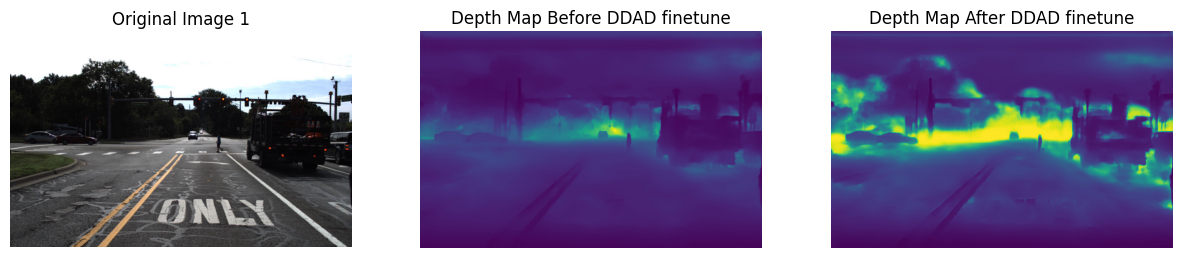

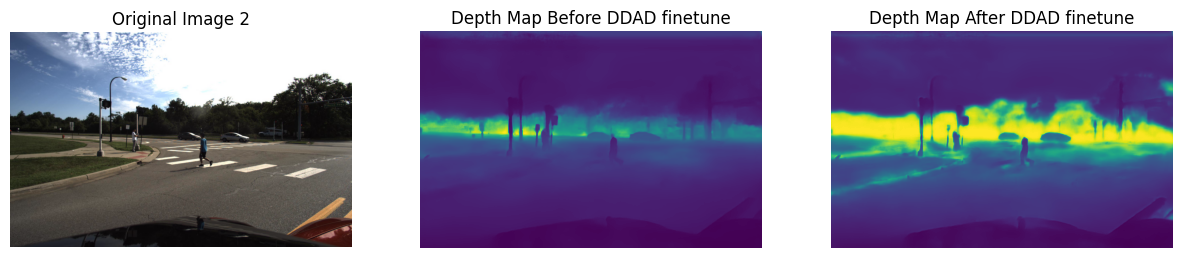

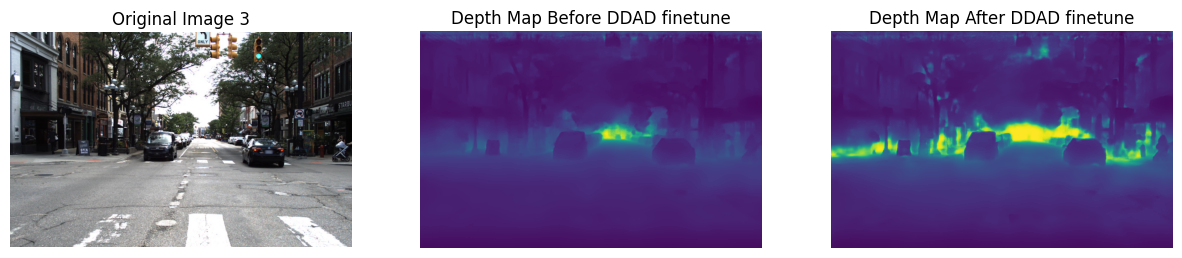

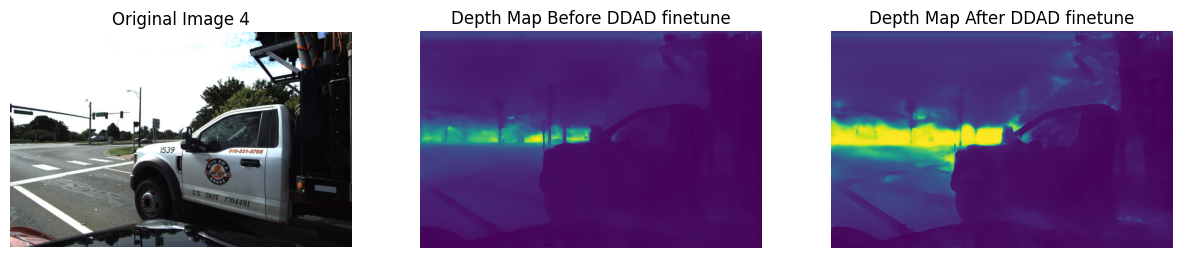

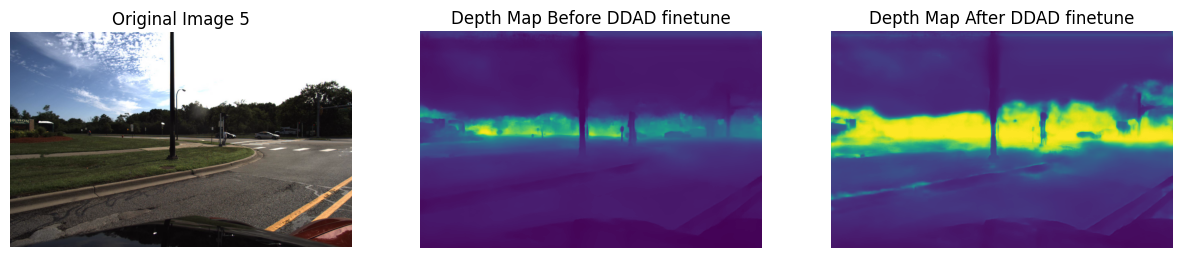

In [ ]:


depth_maps_before = []
depth_maps_after = []

for i in range(5):
    input_image = sampled_images[i]

    # Get depth maps
    with torch.no_grad():  # Disable gradient computation to save memory
        depth_before = get_depth_map(model_before, input_image, image_processor, device)
        depth_after = get_depth_map(model_after, input_image, image_processor, device)
        before_np = depth_before.squeeze().cpu().numpy()
        after_np = depth_after.squeeze().cpu().numpy()

    # Append to lists for later use if necessary
    depth_maps_before.append(depth_before)
    depth_maps_after.append(depth_after)

    # Plot results
    plot_depth_maps(input_image, before_np, after_np, i, 'Original Image', 'Depth Map Before DDAD finetune', 'Depth Map After DDAD finetune')


#### open depth map after fintune

In [ ]:
"""#save depth maps before and after for random samples:
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/depth_maps_before.pkl', 'wb') as f:
    pickle.dump(depth_maps_before, f)
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/depth_maps_after.pkl', 'wb') as f:
    pickle.dump(depth_maps_after, f)"""

"#save depth maps before and after for random samples:\nwith open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/depth_maps_before.pkl', 'wb') as f:\n    pickle.dump(depth_maps_before, f)\nwith open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/depth_maps_after.pkl', 'wb') as f:\n    pickle.dump(depth_maps_after, f)"

In [ ]:
# open the depth maps:
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/depth_maps_before.pkl', 'rb') as f:
    depth_maps_before = pickle.load(f)
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/depth_maps_after.pkl', 'rb') as f:
    depth_maps_after = pickle.load(f)

### Get samples captions:

In [ ]:
"""processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", torch_dtype=torch.float16).to("cuda")
model.eval()"""

In [ ]:
def get_captions(image, device='cuda'):
  text = "a photography of"
  inputs = processor(image, text, return_tensors="pt").to("cuda", torch.float16)
  generated_ids = model.generate(**inputs)
  generated_text = processor.decode(generated_ids[0], skip_special_tokens=True).strip()
  return generated_text

In [ ]:
"""captions=[]
for image in sampled_images:
  print(get_captions(image))
  captions.append(get_captions(image))
#save captions:
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/captions.pkl', 'wb') as f:
    pickle.dump(captions, f)"""

"captions=[]\nfor image in sampled_images:\n  print(get_captions(image))\n  captions.append(get_captions(image))\n#save captions:\nwith open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/captions.pkl', 'wb') as f:\n    pickle.dump(captions, f)"

In [ ]:
#open the caotions;
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/captions.pkl', 'rb') as f:
    captions = pickle.load(f)
captions

['a photography of a street with a sign that says only',
 'a photography of a person crossing a street with a umbrella',
 'a photography of a street with cars and people on it',
 'a photography of a truck driving down a street next to a traffic light',
 'a photography of a street with a car driving down it']

### run the control net on the captions promts

In [ ]:
def convert_depth_map_format(depth_map):
  # Resize and convert depth map to PIL Image
  predicted_depth = torch.nn.functional.interpolate(
      depth_map.unsqueeze(1),
      size=input_image.size[::-1],  # PIL size is (width, height), so reverse
      mode="bilinear",
      align_corners=False,
  ).squeeze()

  # Normalize depth map to range 0-255 and convert to uint8
  depth_map = predicted_depth.cpu().numpy()
  depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
  # Invert the depth map
  depth_map = 1 - depth_map
  depth_map = (depth_map * 255).astype("uint8")

  depth_map_image = Image.fromarray(depth_map)
  return depth_map_image

### plot generated images

generating the pic number 1 with promt: a photography of a street with a sign that says only


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

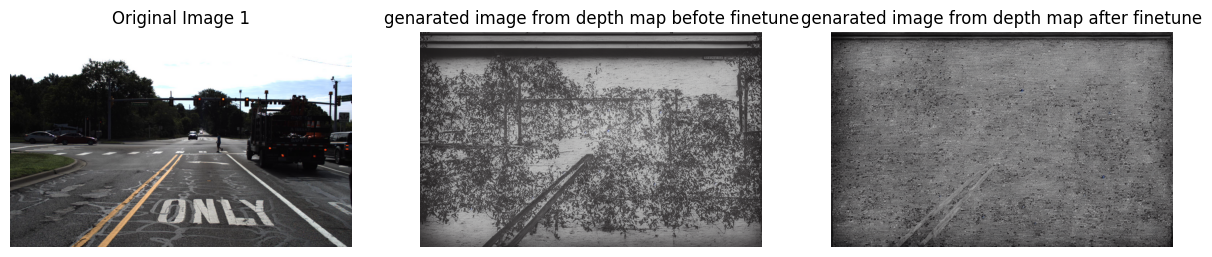

generating the pic number 2 with promt: a photography of a person crossing a street with a umbrella


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

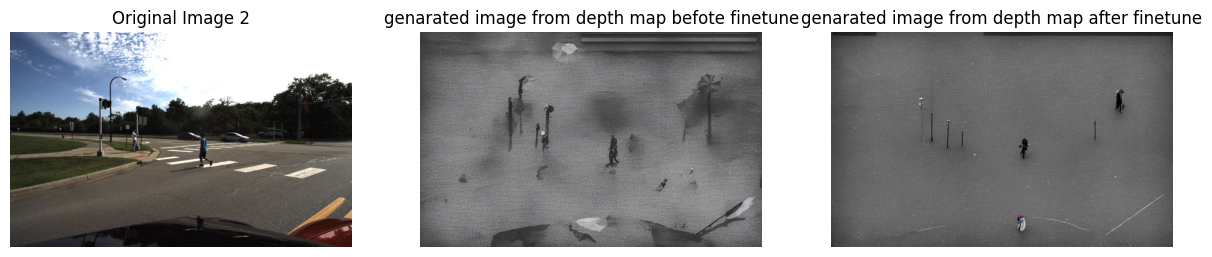

generating the pic number 3 with promt: a photography of a street with cars and people on it


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

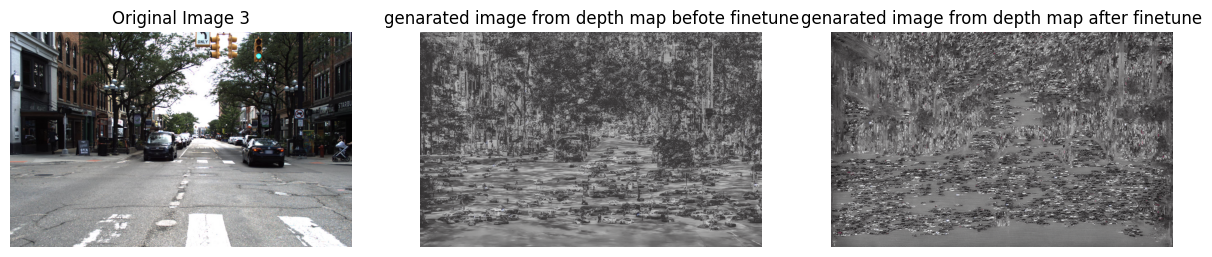

generating the pic number 4 with promt: a photography of a truck driving down a street next to a traffic light


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

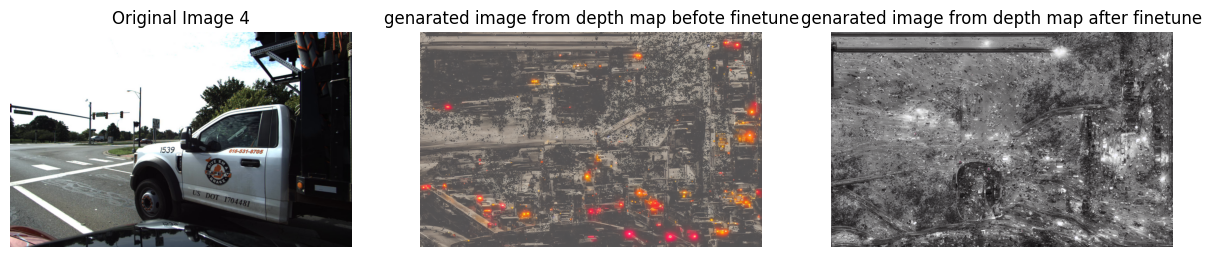

generating the pic number 5 with promt: a photography of a street with a car driving down it


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

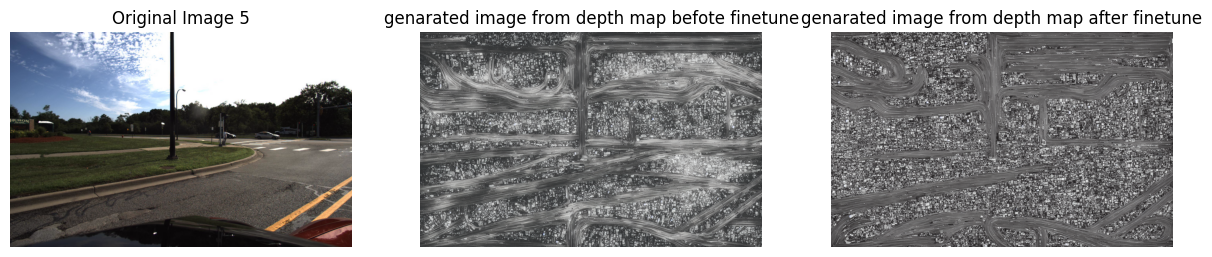

In [ ]:
for i in range(len(depth_maps_before)):
    input_image = sampled_images[i]

    depth_before = depth_maps_before[i]
    depth_after = depth_maps_after[i]
    prompt = captions[i]
    print(f'generating the pic number {i+1} with promt: {prompt}')
    depth_before =convert_depth_map_format(depth_before)
    depth_after = convert_depth_map_format(depth_after)

    # Process images with the pipeline
    res_image_before = pipe(prompt=prompt, image=depth_before, num_inference_steps=50, generator=generator).images[0]
    res_image_after = pipe(prompt=prompt, image=depth_after, num_inference_steps=50, generator=generator).images[0]

    # Plot results
    plot_depth_maps(sampled_images[i], res_image_before, res_image_after, i, 'Original Image', 'genarated image from depth map befote finetune', 'genarated image from depth map after finetune')


### Add the EDB :
1. Use the finetuned model to get the depth
2. Run edb to get the egdes prob
3. get the estimated GT of edges
4. Train using both losses with alpha = 50 to the edges

In [ ]:
def balanced_bce_loss(predicted_edge_proba, gt_edge_proba):
    """
    Calculate the Balanced Binary Cross Entropy loss.

    Args:
        predicted_edge_proba (torch.Tensor): Predicted edge probabilities.
        gt_edge_proba (torch.Tensor): Ground truth edge probabilities.

    Returns:
        torch.Tensor: Balanced BCE loss.
    """
    # Flatten the tensors
    predicted_edge_proba = predicted_edge_proba.view(-1)
    gt_edge_proba = gt_edge_proba.view(-1)

    # Calculate the number of positive and negative samples
    num_pos = gt_edge_proba.sum()
    num_neg = (1 - gt_edge_proba).sum()

    # Avoid division by zero
    num_pos = torch.clamp(num_pos, min=1)
    num_neg = torch.clamp(num_neg, min=1)

    # Calculate weights
    pos_weight = num_neg / (num_pos + num_neg)
    neg_weight = num_pos / (num_pos + num_neg)

    # Calculate BCE loss
    loss_pos = -pos_weight * gt_edge_proba * torch.log(predicted_edge_proba + 1e-6)
    loss_neg = -neg_weight * (1 - gt_edge_proba) * torch.log(1 - predicted_edge_proba + 1e-6)
    loss = loss_pos + loss_neg

    return loss.mean()

In [ ]:
#start training for the finetune checkpoint
model = model_after
# GO_HERE # print weights:
print(model.glpn.encoder.patch_embeddings[0].proj.weight[0][0])

tensor([[-0.0035, -0.0124, -0.0239, -0.0158, -0.0166, -0.0116,  0.0002],
        [ 0.0053,  0.0093, -0.0242, -0.0441,  0.0097, -0.0095, -0.0368],
        [ 0.0086, -0.0022, -0.0839, -0.0315, -0.0049, -0.0644, -0.0569],
        [-0.0031, -0.0939, -0.0137, -0.0013, -0.1459, -0.1013, -0.0503],
        [-0.0278,  0.0028,  0.0845,  0.0553, -0.0312,  0.0044,  0.0491],
        [-0.0052,  0.0414,  0.1014, -0.0044, -0.0751,  0.0013,  0.1142],
        [ 0.0006,  0.0146,  0.0810,  0.0962, -0.0247, -0.0295,  0.0028]],
       device='cuda:0', grad_fn=<SelectBackward0>)


### training the nodel with EDB


In [ ]:
# Ensure model is on GPU
model.to(device)

# Training loop
num_epochs = 10
alpha = 50
# Lists to store loss values
train_losses = []
val_losses = []
edges_loss_list = []
depth_loss_list = []


for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values).predicted_depth

        # Resize the target depth to match the model output size
        output_size = outputs.shape[1:]  # Height and width of model output
        resized_labels = F.interpolate(labels.unsqueeze(1).float(), size=output_size, mode='bilinear', align_corners=False).squeeze(1)

        # Ensure dimensions match
        assert outputs.shape == resized_labels.shape, f"Shape mismatch: {outputs.shape} vs {resized_labels.shape}"
        # Create a mask where the true depth is greater than 0
        mask = resized_labels > 0

        # Apply the mask to the outputs and labels
        masked_outputs = torch.masked_select(outputs, mask)
        masked_labels = torch.masked_select(resized_labels, mask)

        # Calculate loss only on valid pixels
        if masked_labels.numel() > 0:
            depth_loss = criterion(masked_outputs, masked_labels).mean()  # Take mean over valid pixels
        else:
            depth_loss = torch.tensor(0.0, device=device)  # No valid pixels, loss is zero

        # calcualte the edg abd gt results:
        predicted_edge_proba = EDB(outputs, t_grad = 0.5)
        gt_edge_proba = edge_probabilities(outputs, low_threshold=0.85, high_threshold=0.9)

        depth_edges_loss = balanced_bce_loss(predicted_edge_proba, gt_edge_proba)

        loss = depth_loss + alpha*depth_edges_loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)
    # Calculate ARE
    are = calculate_are(outputs, resized_labels)
    print(f"ARE: {are:.4f}")

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values).predicted_depth

            # Resize the target depth to match the model output size
            output_size = outputs.shape[1:]  # Height and width of model output
            resized_labels = F.interpolate(labels.unsqueeze(1).float(), size=output_size, mode='bilinear', align_corners=False).squeeze(1)

            # Ensure dimensions match
            assert outputs.shape == resized_labels.shape, f"Shape mismatch: {outputs.shape} vs {resized_labels.shape}"
            # Create a mask where the true depth is greater than 0
            mask = resized_labels > 0

            # Apply the mask to the outputs and labels
            masked_outputs = torch.masked_select(outputs, mask)
            masked_labels = torch.masked_select(resized_labels, mask)

            # Calculate loss only on valid pixels
            if masked_labels.numel() > 0:
                depth_loss = criterion(masked_outputs, masked_labels).mean()  # Take mean over valid pixels
            else:
                depth_loss = torch.tensor(0.0, device=device)  # No valid pixels, loss is zero


            # calcualte the edg abd gt results:
            predicted_edge_proba = EDB(outputs,t_grad = 0.5)
            gt_edge_proba = edge_probabilities(outputs, low_threshold=0.85, high_threshold=0.9)

            depth_edges_loss = balanced_bce_loss(predicted_edge_proba, gt_edge_proba)

            loss = depth_loss + alpha*depth_edges_loss

            total_val_loss += loss.item()
            # Store the loss values
            print(f'depth_loss: {depth_loss.item()}')
            print(f'depth_edges_loss: {depth_edges_loss.item()}')
            depth_loss_list.append(depth_loss.item())
            edges_loss_list.append(alpha*depth_edges_loss.item())

    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")
    val_losses.append(avg_val_loss)

    # Save model weights
    torch.save(model.state_dict(), f"/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/epoch trianing wights/model_edge_epoch_{epoch+1}.pth")

print("Training complete!")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



Training complete!


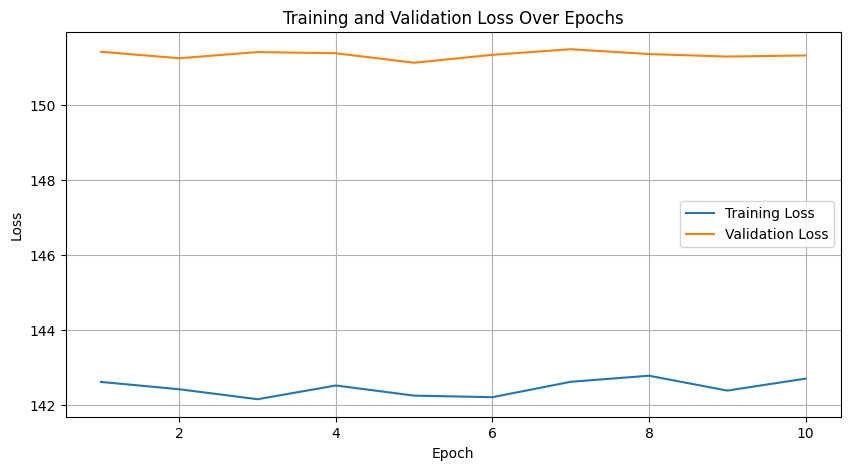

In [ ]:
print("Training complete!")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save model state after fine-tuning
after_train_path = '/content/drive/MyDrive/mind the edge/DDAD/depth_model_after_train_10_epocs.pth'
torch.save(model.state_dict(), after_finetune_path)

In [ ]:
# Load the model after fine-tuning
# model_after = AutoModelForDepthEstimation.from_pretrained(checkpoint)
# model.load_state_dict(torch.load(after_train_path))
# model.to(device)
# model.eval()


In [ ]:
len(depth_loss_list)

130

[112.9534683227539, 123.64510345458984, 129.31741333007812, 157.48391723632812, 152.8076171875, 143.73826599121094, 145.92526245117188, 112.7304916381836, 94.8414306640625, 96.85122680664062, 145.61734008789062, 115.91641235351562, 126.60277557373047, 112.93123626708984, 123.61603546142578, 129.2972412109375, 157.4530487060547, 152.78379821777344, 143.7149200439453, 145.8647918701172, 112.68746185302734, 94.80963897705078, 96.81309509277344, 145.58416748046875, 115.8801040649414, 126.58319854736328, 112.95979309082031, 123.64939880371094, 129.3208770751953, 157.4855194091797, 152.810791015625, 143.7394561767578, 145.92945861816406, 112.73286437988281, 94.84623718261719, 96.8566665649414, 145.6206512451172, 115.92343139648438, 126.60799407958984, 112.96722412109375, 123.65605926513672, 129.3257293701172, 157.4958953857422, 152.82032775878906, 143.74530029296875, 145.93064880371094, 112.73775482177734, 94.85344696044922, 96.86384582519531, 145.63328552246094, 115.92855072021484, 126.6150

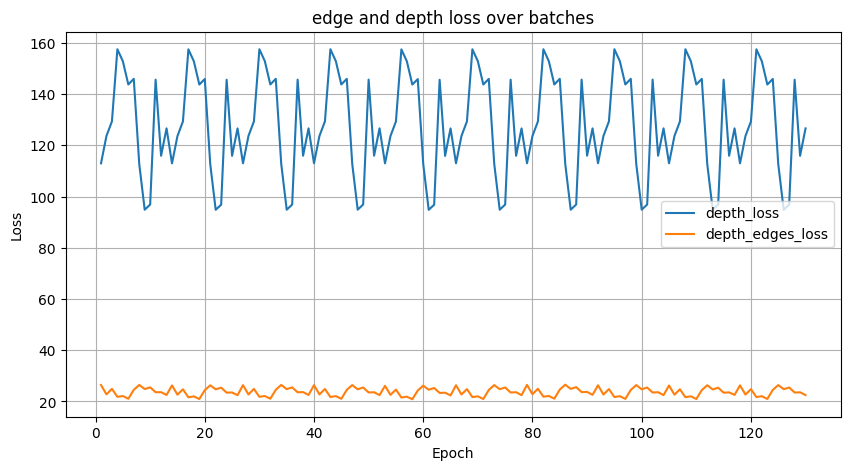

In [ ]:
print(depth_loss_list)
print(edges_loss_list)
# Plot the depth and edge loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 131), depth_loss_list, label='depth_loss')
plt.plot(range(1, 131), edges_loss_list, label='depth_edges_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('edge and depth loss over batches')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# print weights to compare to brfore training
print(model.glpn.encoder.patch_embeddings[0].proj.weight[0][0])

In [ ]:
# Save model state after fine-tuning and edb
after_train_path = '/content/drive/MyDrive/mind the edge/DDAD/depth_model_after_train_a50.pth'
torch.save(model.state_dict(), after_train_path)

In [ ]:
# Load the model after fine-tuning edb
model_after_edb = AutoModelForDepthEstimation.from_pretrained(checkpoint)
model_after_edb.load_state_dict(torch.load(after_finetune_path))
model_after_edb.to(device)

In [ ]:
# Load the sampled images
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/original_samples.pkl', 'rb') as f:
    sampled_images = pickle.load(f)

# Initialize the processor
model_name = "vinvino02/glpn-kitti"
processor = AutoImageProcessor.from_pretrained(model_name)
# Define the model
model = AutoModelForDepthEstimation.from_pretrained(model_name)
model.load_state_dict(torch.load("/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/epoch trianing wights/model_edge_epoch_1.pth"))
model.to(device)
model.eval()

'''
# Load the model before fine-tuning
model_before = AutoModelForDepthEstimation.from_pretrained(checkpoint)
model_before.to(device)

# Load the model after fine-tuning
model_after = AutoModelForDepthEstimation.from_pretrained(checkpoint)
model_after.load_state_dict(torch.load(after_finetune_path))
model_after.to(device)
'''


'\n# Load the model before fine-tuning\nmodel_before = AutoModelForDepthEstimation.from_pretrained(checkpoint)\nmodel_before.to(device)\n\n# Load the model after fine-tuning\nmodel_after = AutoModelForDepthEstimation.from_pretrained(checkpoint)\nmodel_after.load_state_dict(torch.load(after_finetune_path))\nmodel_after.to(device)\n'

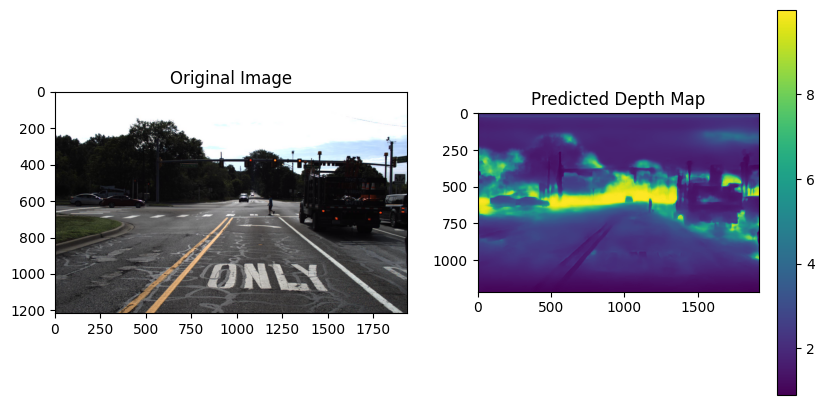

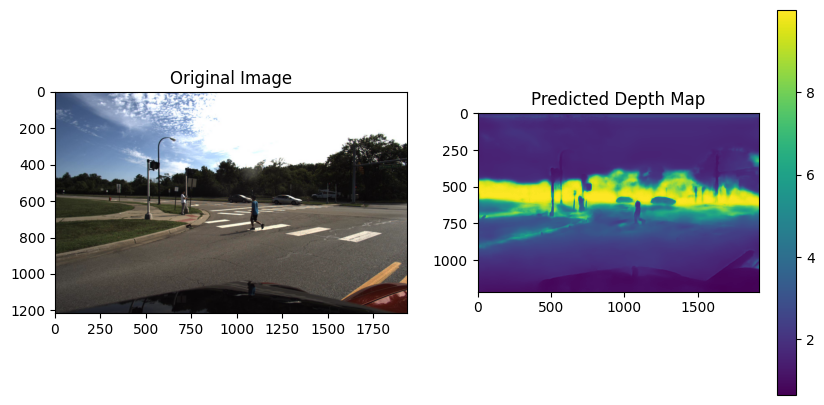

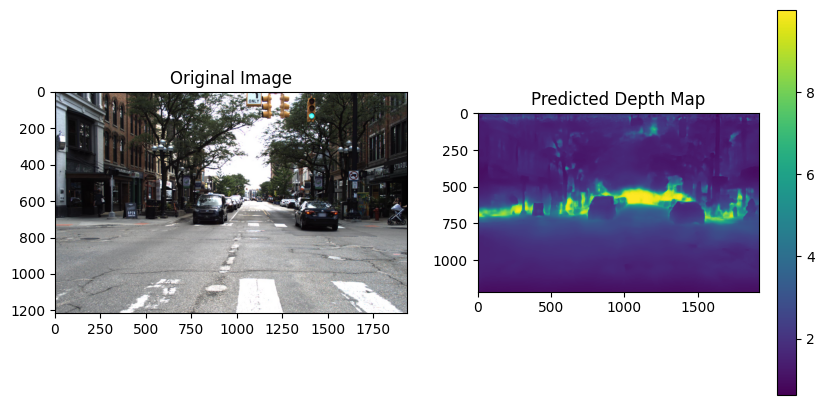

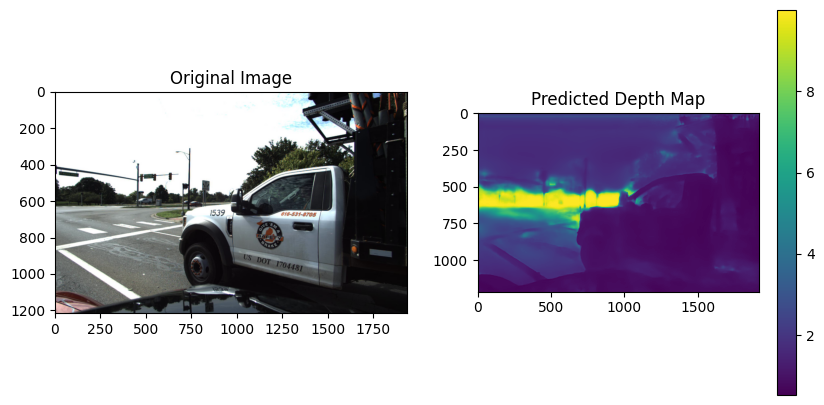

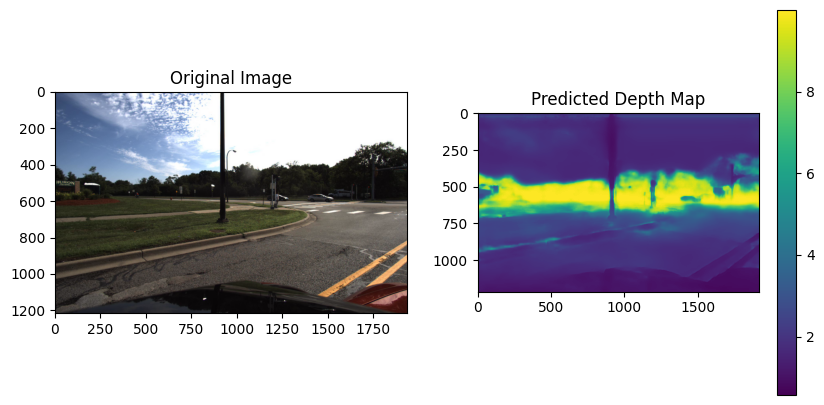

In [ ]:

# Define a function to run inference and visualize depth maps
def run_inference_and_visualize(sampled_images, num_images=5):
    depth_maps_after_trainig = []
    # Run inference and visualize the depth maps
    for i in range(num_images):
        input_image = sampled_images[i]

        # Preprocess the image
        inputs = processor(images=input_image, return_tensors="pt").to(device)

        # # Run inference
        # with torch.no_grad():
        #     outputs = model(**inputs)
        #     predicted_depth = outputs.predicted_depth
        #     # Convert the depth map to the appropriate format for ControlNet
        #     predicted_depth = convert_depth_map_format(predicted_depth)


            ###########
        # Get depth maps
        with torch.no_grad():  # Disable gradient computation to save memory
            predicted_depth = get_depth_map(model, input_image, image_processor, device)
            depth_map_np = predicted_depth.squeeze().cpu().numpy()

        # # Process the predicted depth map
        depth_maps_after_trainig.append(predicted_depth)

        # Visualize the depth map
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_image)
        plt.title("Original Image")
        plt.subplot(1, 2, 2)
        plt.imshow(depth_map_np, cmap='viridis')
        plt.colorbar()
        plt.title("Predicted Depth Map")
        plt.show()

    return depth_maps_after_trainig


# Run inference and visualize the depth maps for the first 5 images
depth_maps = run_inference_and_visualize(sampled_images, num_images=5)




In [ ]:

# save depth maps for random samples:
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/depth_maps_after_trainig.pkl', 'wb') as f:
    pickle.dump(depth_maps, f)


In [ ]:
with open('/content/drive/MyDrive/mind the edge/DDAD/ddad_train_val/depth_maps_after.pkl', 'rb') as f:
      depth_maps = pickle.load(f)

  0%|          | 0/50 [00:00<?, ?it/s]

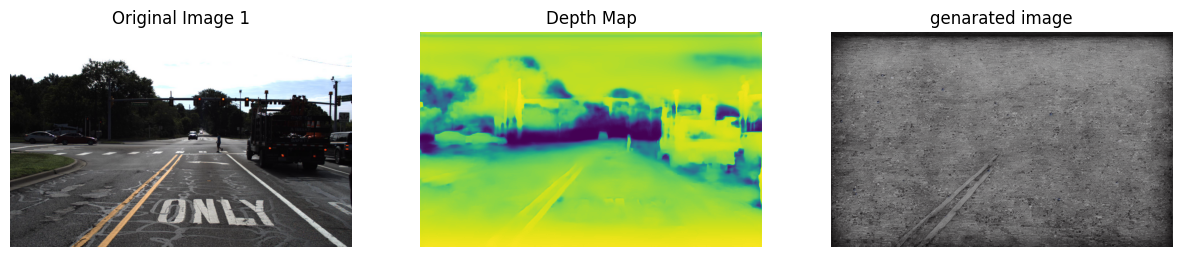

  0%|          | 0/50 [00:00<?, ?it/s]

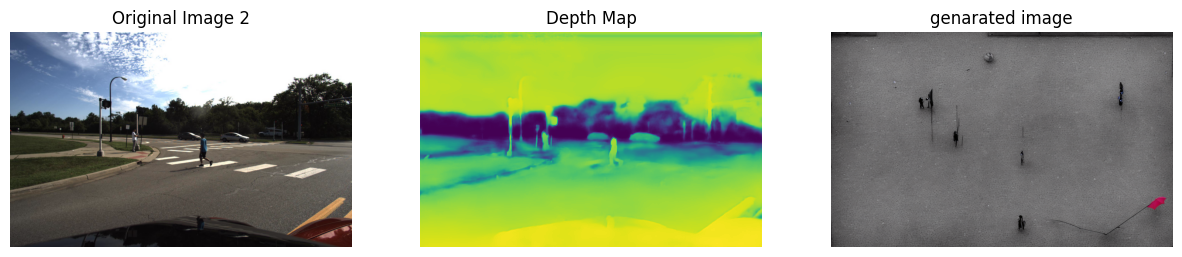

  0%|          | 0/50 [00:00<?, ?it/s]

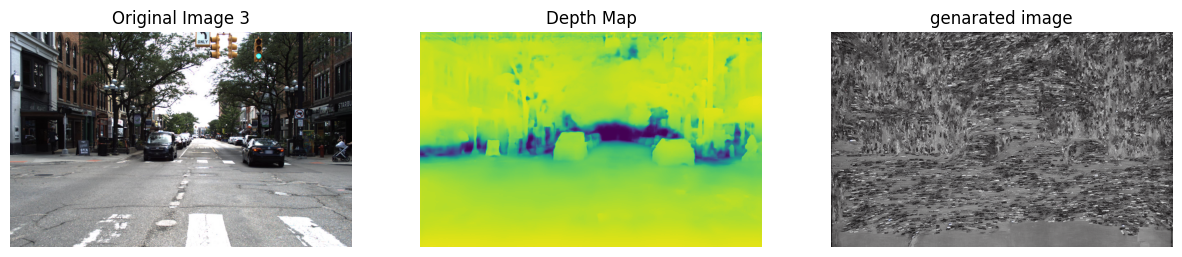

  0%|          | 0/50 [00:00<?, ?it/s]

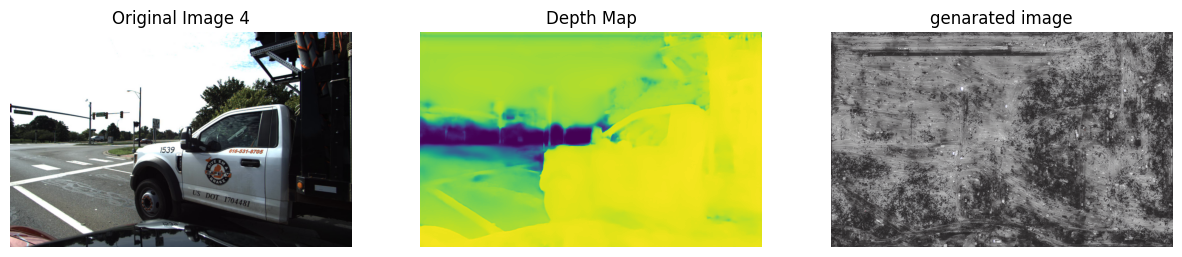

  0%|          | 0/50 [00:00<?, ?it/s]

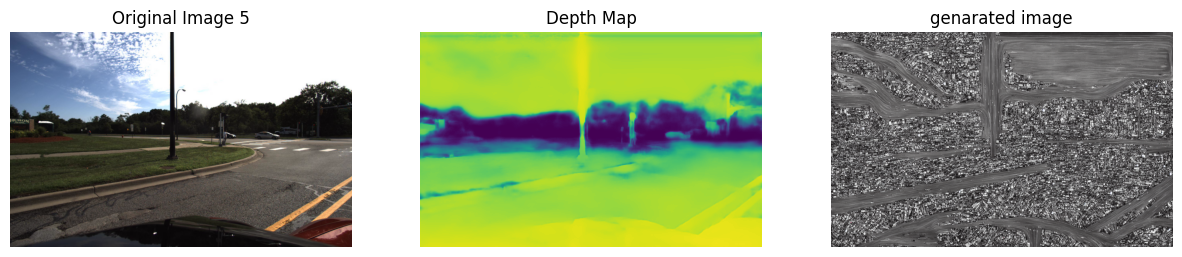

<Figure size 640x480 with 0 Axes>

In [ ]:
results_images = []
for i in range(len(depth_maps)):
    depth_map = depth_maps[i]
    prompt = captions[i]

    depth_before =convert_depth_map_format(depth_map)

    # Process images with the pipeline
    res_image = pipe(prompt=prompt, image=depth_before, num_inference_steps=50, generator=generator).images[0]
    results_images.append(res_image)
    # Plot results
    plot_depth_maps(sampled_images[i], depth_before, res_image, i, 'Original Image', 'Depth Map', 'genarated image')



plt.tight_layout()
plt.show()
